In [1]:
pip install pretrainedmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 452.0 kB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=eb4683de5648e258b336fd5fa45f7b8a38c7d8aefa0a55ebdea557e7d3fa5d7f
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built pretrainedmodels
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import cv2
import json
import torch
import numpy as np 
import pandas as pd 
from PIL import Image 
import torch.nn as nn
from tqdm import tqdm, tqdm_notebook
from matplotlib import pyplot as plt
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.utils.model_zoo as model_zoo
from torchvision.models.resnet import ResNet
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from torchvision.models.resnet import BasicBlock
from torchvision.models.resnet import Bottleneck
from pretrainedmodels.models.torchvision_models import pretrained_settings
import torch.nn.functional as F

In [3]:
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
DATA_MODES = ['train', 'val', 'test']
DEVICE = torch.device("cuda")
RESCALE_SIZE_1 = 448
RESCALE_SIZE_2 = 448

CUDA is available!  Training on GPU ...


In [4]:
def make_mask(img_size,idx,df):
    df = df.iloc[idx,:]
    mask = np.zeros((img_size[0],img_size[1]))
    shape_name = df['name_shape']
    clses = df['cls']
    for i in range(len(clses)):
        shape_name = df['name_shape'][i]
        if shape_name == 'polygon':
            all_x,all_y = df['xy'][i]
            pts = np.array([[int(all_x[k]),int(all_y[k])] for k in range(len(all_x))])
            cv2.fillPoly(mask, [pts], 1)
        if shape_name == 'circle':
            cx,cy,r = df['xy'][i]
            cv2.circle(mask, (int(cx),int(cy)), r, 1,-1)
        if  shape_name == 'ellipse':
            cx,rx,cy,ry = df['xy'][i]
            cv2.ellipse(mask, (int(cx),int(cy)), (int(rx),int(ry)), 0, 0, 360, 1, thickness= -1)
        if shape_name == 'rect':
            x,y,width,height = df['xy'][i]
            cv2.rectangle(mask, (int(x),int(y)), (int(x+width),int(y+height)),1, thickness= -1)
    return mask

In [5]:
TRAIN_PATH = '../input/russian-road-signs-segmentation-dataset/sign_dataset/train/'
VAL_PATH = '../input/russian-road-signs-segmentation-dataset/sign_dataset/val/'
def make_df(path):
    with open(path + 'via_region_data.json') as f:
        templates = json.load(f)
    df = pd.DataFrame(columns =['img','file','cls','name_shape','xy'])
    for item in templates:
        clses = []
        xy = []
        shape = []
        for clss in templates[item]['regions']:
            clses.append(int(clss))
            shape_itm = templates[item]['regions'][clss]['shape_attributes']['name']
            shape.append(shape_itm)
            if shape_itm== 'polygon':
                xy.append([templates[item]['regions'][clss]['shape_attributes']['all_points_x'],
                           templates[item]['regions'][clss]['shape_attributes']['all_points_y']])
            elif shape_itm == 'ellipse':
                xy.append([templates[item]['regions'][clss]['shape_attributes']['cx'],
                          templates[item]['regions'][clss]['shape_attributes']['rx'],
                          templates[item]['regions'][clss]['shape_attributes']['cy'],
                           templates[item]['regions'][clss]['shape_attributes']['ry']])
            elif shape_itm == 'circle':
                xy.append([templates[item]['regions'][clss]['shape_attributes']['cx'],
                           templates[item]['regions'][clss]['shape_attributes']['cy'],
                           templates[item]['regions'][clss]['shape_attributes']['r']])
            else:
                xy.append([templates[item]['regions'][clss]['shape_attributes']['x'],
                           templates[item]['regions'][clss]['shape_attributes']['y'],
                           templates[item]['regions'][clss]['shape_attributes']['width'],
                           templates[item]['regions'][clss]['shape_attributes']['height']])
        row = {'img':int(item.partition('.')[0]),'file': item,'cls': clses,'name_shape':shape,'xy':xy}
        df = df.append(row, ignore_index = True)
    df = df.sort_values(by='img')
    df.reset_index(drop=True, inplace=True)
    df['masks'] = [[make_mask(cv2.imread(path+str(df['img'][i])+'.jpg').shape,i,df)] for i in range(len(df))]
    return df

train_df = make_df(TRAIN_PATH)
train_df.head()    

,img,file,cls,name_shape,xy,masks
0,1,1.jpg143451,"[0, 1, 2, 3, 4]","[polygon, polygon, polygon, polygon, polygon]","[[[937, 999, 1010, 947, 937], [214, 207, 271, ...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
1,2,2.jpg259414,"[0, 1, 2, 3]","[polygon, polygon, polygon, polygon]","[[[1754, 1826, 1837, 1766, 1754], [283, 288, 4...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,3,3.jpg277558,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[polygon, polygon, polygon, polygon, polygon, ...","[[[1719, 1841, 1882, 1745, 1719], [82, 72, 258...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
3,4,4.jpg2126129,"[0, 1, 2, 3]","[polygon, polygon, ellipse, polygon]","[[[1466, 1563, 1654, 1466], [1451, 1147, 1426,...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
4,5,5.jpg85057,"[0, 1]","[rect, polygon]","[[1183, 190, 79, 112], [[1242, 1217, 1231, 125...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."


In [6]:
val_df = make_df(VAL_PATH)
val_df.head()   

,img,file,cls,name_shape,xy,masks
0,201,201.jpg132432,"[0, 1, 2]","[circle, polygon, polygon]","[[1101, 264, 57], [[1007, 1168, 1097, 1007], [...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
1,202,202.jpg113571,"[0, 1, 2]","[polygon, polygon, polygon]","[[[983, 1107, 1101, 974, 983], [255, 275, 403,...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,203,203.jpg85896,"[0, 1, 2]","[polygon, polygon, polygon]","[[[1091, 1161, 1165, 1097, 1091], [211, 209, 3...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
3,204,204.jpg105343,"[0, 1, 2]","[polygon, polygon, polygon]","[[[1237, 1199, 1279, 1276, 1237], [99, 182, 18...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
4,205,205.jpg243722,"[0, 1, 2]","[polygon, polygon, polygon]","[[[1833, 1917, 1917, 1850, 1833], [109, 74, 14...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."


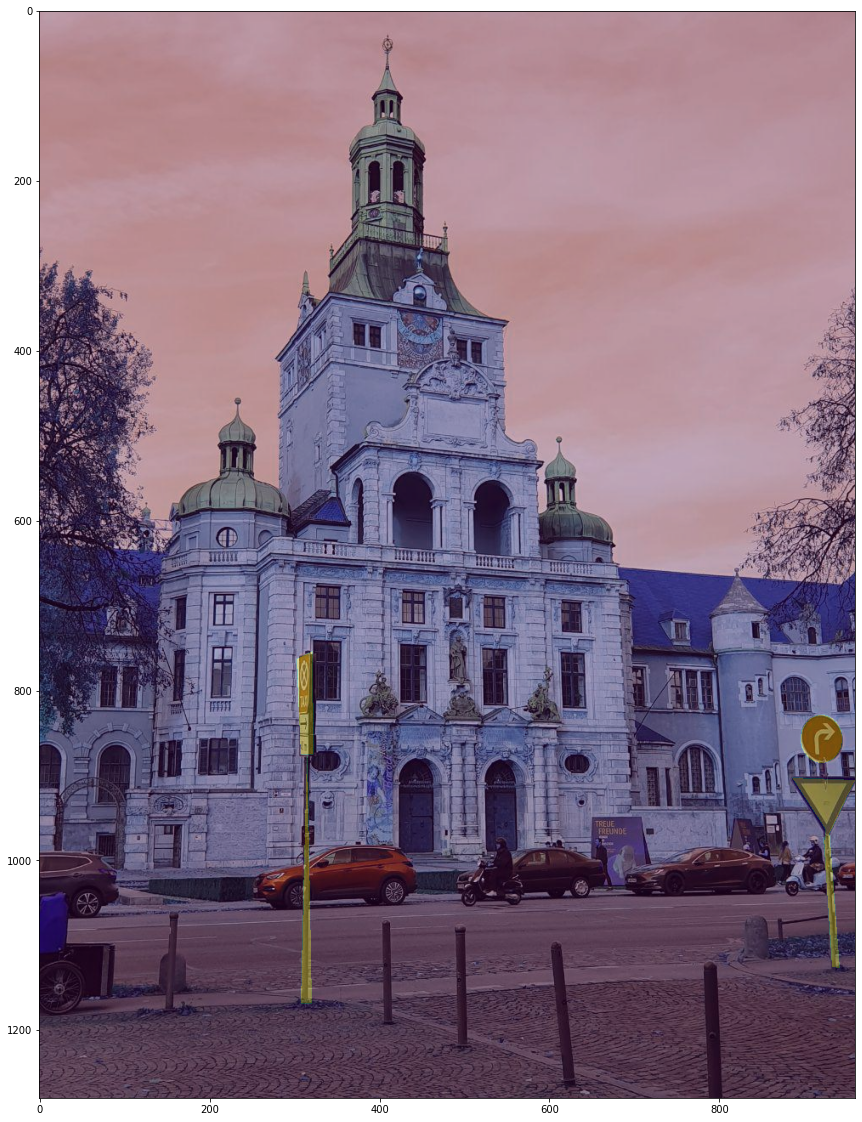

In [7]:
n = 200
igg = cv2.imread(TRAIN_PATH+str(train_df['img'][n])+'.jpg')
igg1 = igg.copy()
plt.figure(figsize=(20,20))
plt.imshow(igg1)
plt.imshow(train_df['masks'][n][0], alpha=0.3)

In [8]:
class RoadSignDataset(Dataset):
    def __init__(self, names, df, mode):
        super().__init__()
        self.names = names
        self.mode = mode
        self.df = df
        self.len_ = len(self.names)

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError
        
    def __len__(self):
        return self.len_
      
    def load_sample(self, file, mode):
        if mode == 'test':
            image = Image.open('../input/signs-1/' + str(file)+'.jpg').convert("RGB")
        elif mode == 'train':
            image = Image.open(TRAIN_PATH + str(file) +'.jpg').convert("RGB")
        elif mode == 'val':
            image = Image.open(VAL_PATH + str(file) +'.jpg').convert("RGB")
        image.load()
        return image
    
    def __getitem__(self, index):
            transforms = T.Compose([T.ToTensor(),
                         T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])
            row = self.df.loc[self.df['file'] == self.names[index]]
            x = self.load_sample(row['img'].item(), self.mode)
            x = self._prepare_sample(x)
            x = np.array(x, dtype='float32')/ 255
            x = transforms(x)
            if self.mode == 'test':
                return x, torch.zeros((RESCALE_SIZE_1,RESCALE_SIZE_2)).reshape((1,RESCALE_SIZE_1,RESCALE_SIZE_2))
            else:
                masks = row['masks'].item()[0]
                masks = np.array(self._prepare_sample(Image.fromarray(masks.astype(np.uint8))))
                masks = torch.as_tensor(masks, dtype=torch.float32)
                return x, masks.reshape(1,RESCALE_SIZE_1,RESCALE_SIZE_2)
    
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE_1, RESCALE_SIZE_2))
        return image

In [9]:
val_dataset = RoadSignDataset(val_df['file'], val_df,  mode='val')
train_dataset = RoadSignDataset(train_df['file'],train_df, mode='train')
# test_dataset = 

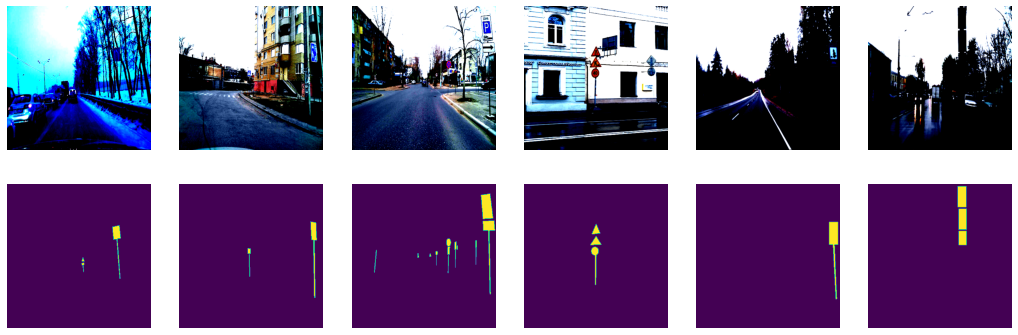

In [10]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(train_dataset[i][0].numpy().transpose(1, 2, 0) )

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(train_dataset[i][1][0])
plt.show();

In [12]:
class Model(nn.Module):

    def __init__(self):
        super().__init__()

    def initialize(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


class Conv2dReLU(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding=0,
                 stride=1, use_batchnorm=True, **batchnorm_params):

        super().__init__()

        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size,
                              stride=stride, padding=padding, bias=not (use_batchnorm)),
            nn.ReLU(inplace=True),
        ]

        if use_batchnorm:
            layers.insert(1, nn.BatchNorm2d(out_channels, **batchnorm_params))

        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)


class EncoderDecoder(Model):

    def __init__(self, encoder, decoder, activation):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

        if callable(activation) or activation is None:
            self.activation = activation
        elif activation == 'softmax':
            self.activation = nn.Softmax(dim=1)
        elif activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        else:
            raise ValueError('Activation should be "sigmoid"/"softmax"/callable/None')

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def predict(self, x):
        if self.training:
            self.eval()

        with torch.no_grad():
            x = self.forward(x)
            if self.activation:
                x = self.activation(x)

        return x


class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_batchnorm=True):
        super().__init__()
        self.block = nn.Sequential(
            Conv2dReLU(in_channels, out_channels, kernel_size=3, padding=1, use_batchnorm=use_batchnorm),
            Conv2dReLU(out_channels, out_channels, kernel_size=3, padding=1, use_batchnorm=use_batchnorm),
        )

    def forward(self, x):
        x, skip = x
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        if skip is not None:
            x = torch.cat([x, skip], dim=1)
        x = self.block(x)
        return x


class CenterBlock(DecoderBlock):

    def forward(self, x):
        return self.block(x)


class UnetDecoder(Model):

    def __init__(
            self,
            encoder_channels,
            decoder_channels=(256, 128, 64, 32, 16),
            final_channels=1,
            use_batchnorm=True,
            center=False,
    ):
        super().__init__()

        if center:
            channels = encoder_channels[0]
            self.center = CenterBlock(channels, channels, use_batchnorm=use_batchnorm)
        else:
            self.center = None

        in_channels = self.compute_channels(encoder_channels, decoder_channels)
        out_channels = decoder_channels

        self.layer1 = DecoderBlock(in_channels[0], out_channels[0], use_batchnorm=use_batchnorm)
        self.layer2 = DecoderBlock(in_channels[1], out_channels[1], use_batchnorm=use_batchnorm)
        self.layer3 = DecoderBlock(in_channels[2], out_channels[2], use_batchnorm=use_batchnorm)
        self.layer4 = DecoderBlock(in_channels[3], out_channels[3], use_batchnorm=use_batchnorm)
        self.layer5 = DecoderBlock(in_channels[4], out_channels[4], use_batchnorm=use_batchnorm)
        self.final_conv = nn.Conv2d(out_channels[4], final_channels, kernel_size=(1, 1))

        self.initialize()

    def compute_channels(self, encoder_channels, decoder_channels):
        channels = [
            encoder_channels[0] + encoder_channels[1],
            encoder_channels[2] + decoder_channels[0],
            encoder_channels[3] + decoder_channels[1],
            encoder_channels[4] + decoder_channels[2],
            0 + decoder_channels[3],
        ]
        return channels

    def forward(self, x):
        encoder_head = x[0]
        skips = x[1:]

        if self.center:
            encoder_head = self.center(encoder_head)

        x = self.layer1([encoder_head, skips[0]])
        x = self.layer2([x, skips[1]])
        x = self.layer3([x, skips[2]])
        x = self.layer4([x, skips[3]])
        x = self.layer5([x, None])
        x = self.final_conv(x)

        return x


class ResNetEncoder(ResNet):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pretrained = False
        del self.fc

    def forward(self, x):
        x0 = self.conv1(x)
        x0 = self.bn1(x0)
        x0 = self.relu(x0)

        x1 = self.maxpool(x0)
        x1 = self.layer1(x1)

        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)

        return [x4, x3, x2, x1, x0]

    def load_state_dict(self, state_dict, **kwargs):
        state_dict.pop('fc.bias')
        state_dict.pop('fc.weight')
        super().load_state_dict(state_dict, **kwargs)


resnet_encoders = {
    'resnet18': {
        'encoder': ResNetEncoder,
        'pretrained_settings': pretrained_settings['resnet18'],
        'out_shapes': (512, 256, 128, 64, 64),
        'params': {
            'block': BasicBlock,
            'layers': [2, 2, 2, 2],
        },
    }
}

encoders = {}
encoders.update(resnet_encoders)

def get_encoder(name, encoder_weights=None):
    Encoder = encoders[name]['encoder']
    encoder = Encoder(**encoders[name]['params'])
    encoder.out_shapes = encoders[name]['out_shapes']

    if encoder_weights is not None:
        settings = encoders[name]['pretrained_settings'][encoder_weights]
        encoder.load_state_dict(model_zoo.load_url(settings['url']))

    return encoder


def get_encoder_names():
    return list(encoders.keys())


class Unet(EncoderDecoder):

    def __init__(
            self,
            encoder_name='resnet34',
            encoder_weights='imagenet',
            decoder_use_batchnorm=True,
            decoder_channels=(256, 128, 64, 32, 16),
            classes=1,
            activation='sigmoid',
            center=False,  # usefull for VGG models
    ):
        encoder = get_encoder(
            encoder_name,
            encoder_weights=encoder_weights
        )

        decoder = UnetDecoder(
            encoder_channels=encoder.out_shapes,
            decoder_channels=decoder_channels,
            final_channels=classes,
            use_batchnorm=decoder_use_batchnorm,
            center=center,
        )

        super().__init__(encoder, decoder, activation)

In [13]:
def fit_epoch(model, train_loader, criterion, optimizer, batch_size):
    model.train()
    running_loss = 0.0
    l2_metric = 0.0
    iou = 0.0
    sigm = nn.Sigmoid()
    for X_batch, Y_batch in train_loader:
        inputs = X_batch.to(DEVICE)
        labels = Y_batch.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = sigm(outputs)
#         print(outputs)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.detach().cpu().numpy() 
        l2_metric += l2(outputs, labels)
        i,pr,r = iou_pr(outputs, labels)
        iou += i
    
    train_loss = running_loss / len(train_loader)
    train_l2 = l2_metric / len(train_loader)
    train_IoU = iou / len(train_loader)
    return train_loss, train_l2, train_IoU

In [14]:
def eval_epoch(model, val_loader, criterion, batch_size):
    model.eval()
    l2_metric = 0.0
    iou = 0.0
    running_loss = 0.0
    sigm = nn.Sigmoid()
    for X_batch, Y_batch in val_loader:
        inputs = X_batch.to(DEVICE)
        labels = Y_batch.to(DEVICE)

        with torch.no_grad():
            outputs = model(inputs)
            outputs = sigm(outputs)
            loss = criterion(outputs,labels)
            running_loss += loss.item()
            i,pr,r = iou_pr(outputs, labels)
            iou += i
            l2_metric += l2(outputs, labels)
    val_loss = running_loss / len(val_loader)
    val_IoU = iou / len(val_loader)
    val_l2 = l2_metric/len(val_loader)
    plt.figure(figsize=(8, 8))
    for k in range(1):
            plt.subplot(1, 3, 1)
            plt.imshow(np.rollaxis(inputs[k].detach().cpu().numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.imshow(outputs[k, 0].detach().cpu().numpy(), cmap='gray')
            plt.title('Output '+str(round(val_IoU,4)))
            plt.axis('off')
            
            plt.subplot(1, 3, 3)
            plt.imshow(labels[k, 0].detach().cpu().numpy(), cmap='gray')
            plt.title('True')
            plt.axis('off')
    plt.show()
    return val_loss, val_l2, val_IoU

In [15]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size,num_workers = 2, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size,num_workers = 2, shuffle=False)
    history = []
#     maxIoU = 0
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} train_l2: {t_l2:0.4f} train_IoU: {t_iou:0.4f}\
    \nValidation  val_loss: {v_loss:0.4f} val_l2: {v_l2:0.4f} val_IoU: {v_iou: 0.4f}"
    criterion = nn.BCELoss()
    params = model.parameters()
    opt = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(opt,
                                                   step_size=15,
                                                   gamma=0.2)
    with tqdm(desc="epoch", total=epochs) as pbar_outer:

        for epoch in range(epochs):
            train_loss, train_l2, train_IoU = fit_epoch(model, train_loader, criterion, opt, batch_size)
            val_loss, val_l2, val_IoU = eval_epoch(model, val_loader, criterion, batch_size)
            lr_scheduler.step() 
            history.append((train_loss, train_l2, train_IoU, val_loss, val_l2, val_IoU))
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss, t_l2 = train_l2, t_iou = round(train_IoU,4), \
                                           v_loss=val_loss, v_l2 = val_l2, v_iou = round(val_IoU,4) ))   
    return history

In [16]:
def iou_pr(outputs: torch.Tensor, labels: torch.Tensor):
    outputs = (outputs >0.2).float()
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    outputs = outputs.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()

    intersection = (outputs & labels).sum()  
    union = (outputs | labels).sum()        
    
    iou = (intersection+SMOOTH) / (union+SMOOTH) 
    presicion = (intersection+SMOOTH)/(outputs.sum()+SMOOTH)
    recall = (intersection +SMOOTH)/(labels.sum()+SMOOTH)
    return np.mean(iou), np.mean(presicion), np.mean(recall) #thresholded 


def l2(outputs: torch.Tensor, labels: torch.Tensor):
    outputs = (outputs >0.2).float()
    outputs = outputs.squeeze(1).byte()
    labels = labels.squeeze(1).byte()
    metric = torch.sqrt(torch.sum(torch.square(labels-outputs)))
    return metric.detach().cpu().numpy()

In [17]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [18]:
# torch.save(unet, './unett.dat')

In [20]:
# unet =  UNet().to(DEVICE)
unet = Unet("resnet18", encoder_weights="imagenet", classes=1, activation=None)
unet = unet.to(DEVICE)
# history = train(train_dataset, val_dataset, model = unet, epochs = 30, batch_size = 10)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [26]:
unet = torch.load('../input/unet-res/unett.dat')

In [33]:
def make_test_with_score(model, test_data):
    loader = DataLoader(test_data, batch_size=1,num_workers = 2, shuffle=False)
    model.eval()
    l2_metric = []
    iou = []
    pres = []
    rec = []
    with tqdm(desc="img", total=len(loader)) as pbar_outer:
        for X_batch, Y_batch in loader:
#         print(X_batch)
            inputs = X_batch.to(DEVICE)
            labels = Y_batch.to(DEVICE)

            with torch.no_grad():
                outputs = model(inputs)
                outputs = (outputs >= 0.3).float()  
                i,pr,r = iou_pr(outputs, labels)
#                 print(pr,r)
                iou.append(i)
                pres.append(pr)
                rec.append(r)
                l2_metric.append(l2(outputs, labels))
                pbar_outer.update(1)
    iou_th = [0.5, 0.75, 0.9]
    num_iou = []
    all_iou = len(iou)
    for item in iou_th:
        num_iou.append((np.array(iou)>=item).sum()/all_iou)
    print('iou: ', np.mean(np.array(iou)))
    print('presicion: ', np.mean(np.array(pres)))
    print('recall: ', np.mean(np.array(rec)))
    print('l2: ', np.mean(np.array(l2_metric)))
    print('iou > 0.5: ', round(num_iou[0]*100),'%')
    print('iou > 0.75: ', round(num_iou[1]*100),'%')
    print('iou > 0.9: ', round(num_iou[2]*100),'%')
#     return np.mean(np.array(iou)), np.mean(np.array(pres)), np.mean(np.array(rec)), np.mean(np.array(l2_metric)),num_iou

In [34]:
make_test_with_score(unet, val_dataset)

img: 100%|██████████| 127/127 [00:09<00:00, 13.83it/s]

iou:  0.6608320368588351
presicion:  0.9105495601696044
recall:  0.7134768400105141
l2:  20.247017
iou > 0.5:  79 %
iou > 0.75:  49 %
iou > 0.9:  10 %


In [63]:
def predict_one_sample(model, data):
    loader = DataLoader(data, batch_size=1,num_workers = 2, shuffle=False)
    model.eval() 
    for inputs, labels in loader:
        Y_pred = model(inputs.to(DEVICE))
        Y_pred = (Y_pred>0.1).float()
        plt.figure(figsize=(20, 20))
        for k in range(1):
            plt.subplot(1, 2, k+1)
            plt.imshow(np.rollaxis(inputs[0].detach().cpu().numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(1, 2, k+2)
            plt.imshow(Y_pred[0, 0].detach().cpu().numpy(), cmap='gray')
            plt.title('Output ')
            plt.axis('off')

    plt.show()

In [53]:
files = os.listdir('../input/signs-1')[5:]
test_df = pd.DataFrame()
test_df['file'] = files
test_df['img'] = [file.replace('.jpg','') for file in files]
test_df.head()

,file,img
0,1.jpg,1
1,7.jpg,7
2,4.jpg,4
3,3.jpg,3
4,2.jpg,2


Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/queues.py", line 232, in _feed
    close()
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/multiprocessing/queues.py", line 263, in _feed
    queue_sem.release()
ValueError: semaphore or lock released too many times



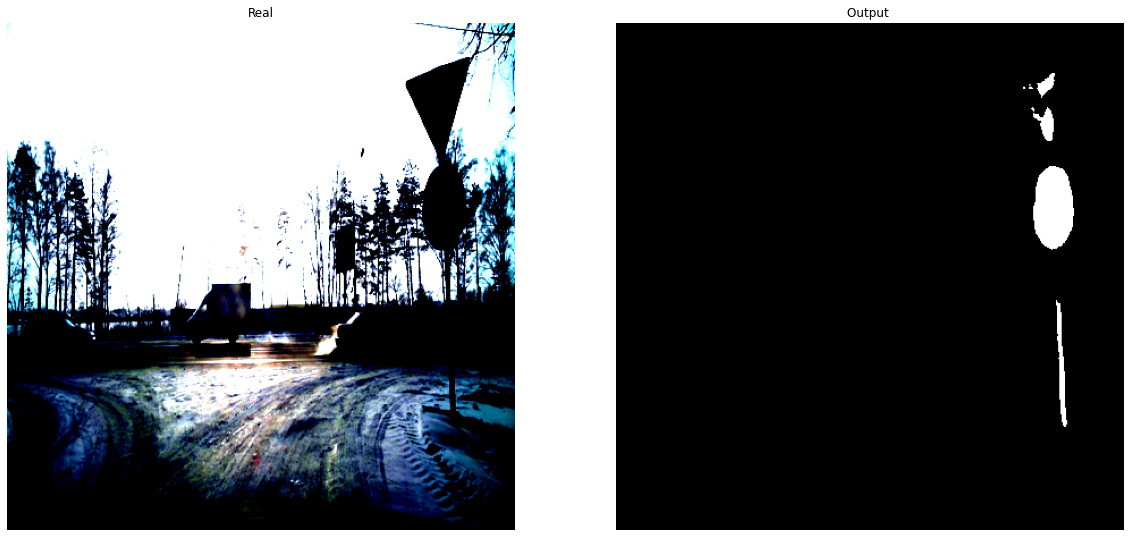

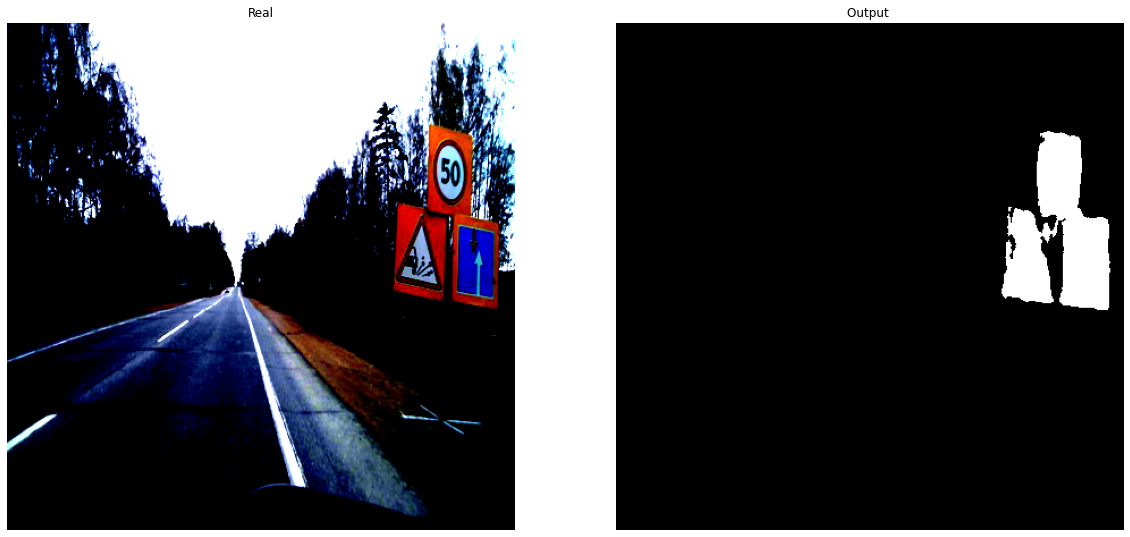

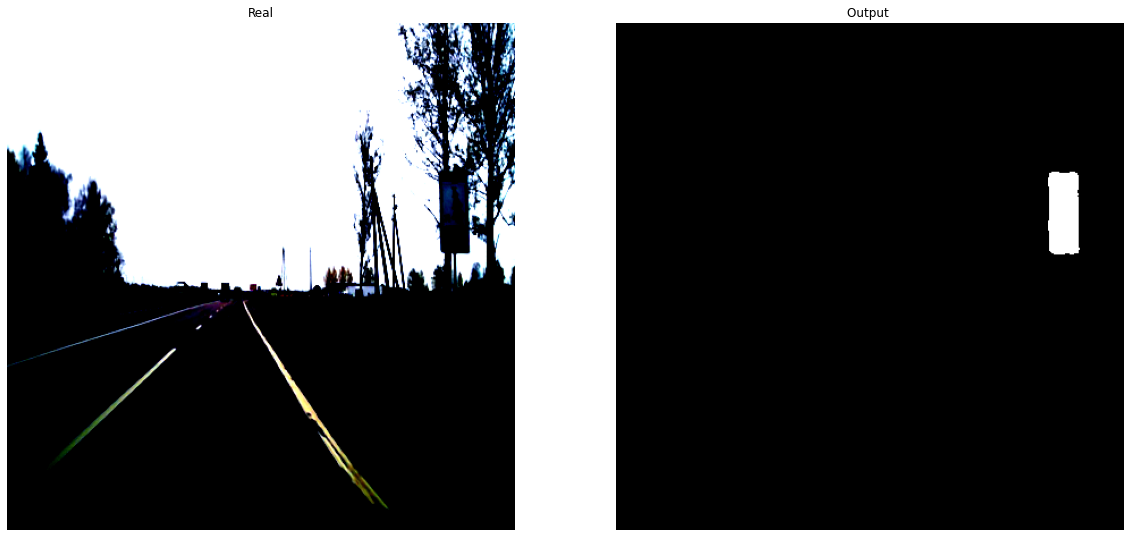

In [64]:
test_dataset = RoadSignDataset(val_df['file'][:3], val_df,  mode='val')
predict_one_sample(unet,test_dataset)